In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cooltools
import cooler

加载 Homo 样本数据...
加载 Het 样本数据...
矩阵大小: 2645 x 2645
创建组合矩阵...
创建对角线分割矩阵...
染色体起始位置: [0, 195, 377, 537, 693, 844, 993, 1138, 1267, 1391, 1521, 1643, 1763, 1883, 2007, 2111, 2209, 2303, 2393, 2454]
染色体中心位置: [97, 286, 457, 615, 768, 918, 1065, 1202, 1329, 1456, 1582, 1703, 1823, 1945, 2059, 2160, 2256, 2348, 2423, 2539]


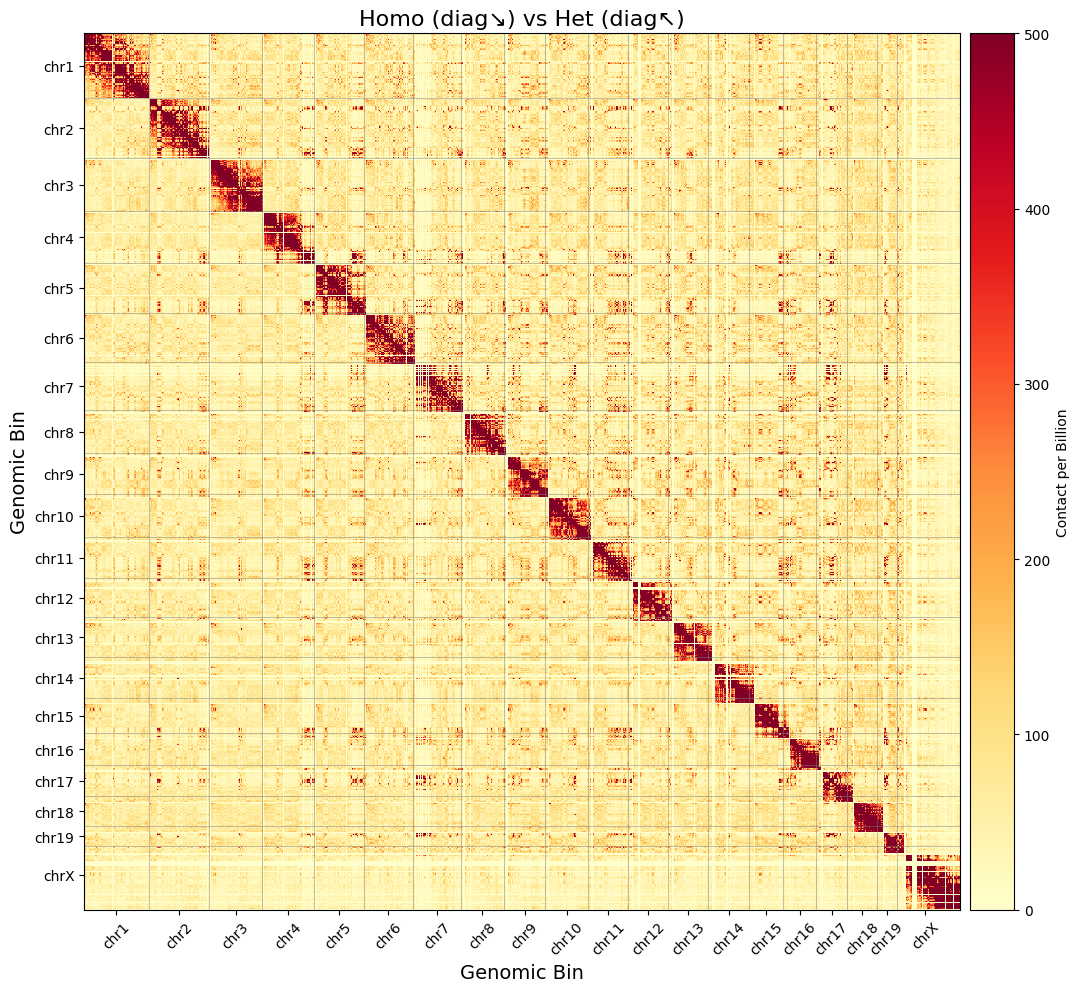

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import cooler
from matplotlib.cm import ScalarMappable

# 设置样本名
sample_homo = 'Homo'
sample_het = 'Het'
data_dir = '/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_output'
chromosomes_to_plot = [f'chr{i}' for i in range(1, 20)] + ['chrX']
resolution = 1000000  # 1Mb

# 从 chromsizes 中筛选只保留 chr1–chr19 和 chrX 的项
chromsizes_filtered = {chrom: size for chrom, size in clr_homo.chromsizes.items() if chrom in chromosomes_to_plot}

def load_contact_freq(sample):
    clr = cooler.Cooler(f'{data_dir}/{sample}/{sample}.valid_pairs.5000.zoomify.mcool::resolutions/{resolution}')
    pixels = clr.pixels()[:]
    bins = clr.bins()[:]

    weights = bins["weight"].values
    bin1_weights = weights[pixels["bin1_id"].values]
    bin2_weights = weights[pixels["bin2_id"].values]
    # 替换 NaN 权重为 0
    bin1_weights = np.nan_to_num(bin1_weights, nan=0.0)
    bin2_weights = np.nan_to_num(bin2_weights, nan=0.0)
    
    balanced_counts = pixels["count"].values * bin1_weights * bin2_weights
    
    n_bins = len(bins)
    # 构建稀疏矩阵并转换为 dense
    mat = coo_matrix((balanced_counts, (pixels["bin1_id"], pixels["bin2_id"])),
                     shape=(n_bins, n_bins)).todense()
    mat = np.array(mat)
    
    # 防止对角线加倍重复
    mat = mat + mat.T
    np.fill_diagonal(mat, np.diag(mat) / 2)

    total = np.nansum(mat)
    contact_freq = mat / total * 1e9
    contact_freq = np.nan_to_num(contact_freq, nan=0.0, posinf=0.0, neginf=0.0)

    return contact_freq, clr

print("加载 Homo 样本数据...")
cf_homo, clr_homo = load_contact_freq(sample_homo)
print("加载 Het 样本数据...")
cf_het, clr_het = load_contact_freq(sample_het)

clr_homo = cooler.Cooler(f'{data_dir}/Homo/Homo.valid_pairs.5000.zoomify.mcool::resolutions/{resolution}')
bins_df = clr_homo.bins()[:]
chrom_bin_counts = bins_df['chrom'].value_counts()

chromstarts_new = []
current_start = 0
for chrom in chromosomes_to_plot:
    if chrom in chrom_bin_counts:
        chrom_bins = chrom_bin_counts[chrom]
        current_start += chrom_bins
        chromstarts_new.append(current_start)

max_bin = current_start

cf_homo = cf_homo[:max_bin, :max_bin]
cf_het = cf_het[:max_bin, :max_bin]

print(f"矩阵大小: {max_bin} x {max_bin}")
print("创建组合矩阵...")

vmin = 0
vmax = 500
# 如果需要对角线分割效果，可以使用下面的优化版本
def create_diagonal_split_matrix(mat_homo, mat_het):
    """创建对角线分割的矩阵用于特殊显示效果"""
    n = mat_homo.shape[0]
    # 创建两个RGB图像
    homo_rgb = plt.cm.YlOrRd(np.clip((mat_homo - vmin) / (vmax - vmin), 0, 1))
    het_rgb = plt.cm.YlOrRd(np.clip((mat_het - vmin) / (vmax - vmin), 0, 1))
    
    # 创建组合RGB矩阵
    combined_rgb = np.zeros((n, n, 4))  # RGBA
    
    # 上三角：Het
    for i in range(n):
        for j in range(i+1, n):
            combined_rgb[i, j] = het_rgb[i, j]
    
    # 下三角：Homo  
    for i in range(n):
        for j in range(i):
            combined_rgb[i, j] = homo_rgb[i, j]
    
    # 对角线分割
    for i in range(n):
        # 可以选择不同的分割方式
        combined_rgb[i, i] = (homo_rgb[i, i] + het_rgb[i, i]) / 2
    
    return combined_rgb

print("创建对角线分割矩阵...")
diagonal_split_rgb = create_diagonal_split_matrix(cf_homo, cf_het)

# 计算染色体起始位置和中心位置
chromstarts_new = []
chrom_centers = []
current_start = 0

for chrom in chromosomes_to_plot:
    bins_in_chrom = chromsizes_filtered[chrom] // resolution
    chromstarts_new.append(current_start)
    
    # 计算染色体中心位置
    chrom_center = current_start + bins_in_chrom // 2
    chrom_centers.append(chrom_center)
    
    current_start += bins_in_chrom

print(f"染色体起始位置: {chromstarts_new}")
print(f"染色体中心位置: {chrom_centers}")

fig2, ax2 = plt.subplots(figsize=(12, 12))
ax2.imshow(diagonal_split_rgb, interpolation='nearest', origin='upper')

# 添加边界线和标签（与上面相同）
for pos in chromstarts_new:
    ax2.axvline(pos - 0.5, color='gray', linewidth=0.5, alpha=0.7)
    ax2.axhline(pos - 0.5, color='gray', linewidth=0.5, alpha=0.7)

ax2.set_xlim(-0.5, max_bin - 0.5)
ax2.set_ylim(max_bin - 0.5, -0.5)
ax2.set_title(f'{sample_homo} (diag↘) vs {sample_het} (diag↖)', fontsize=16)
ax2.set_xlabel('Genomic Bin', fontsize=14)
ax2.set_ylabel('Genomic Bin', fontsize=14)

ax2.set_xticks(chrom_centers)
ax2.set_xticklabels(chromosomes_to_plot, rotation=45)
ax2.set_yticks(chrom_centers)
ax2.set_yticklabels(chromosomes_to_plot)

sm = ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# 设置 colorbar 高度与主图一致
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)

# 添加 colorbar
sm = ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar2 = plt.colorbar(sm, cax=cax)
cbar2.set_label('Contact per Billion')

plt.savefig(f'../plots_v1/{sample_homo}_vs_{sample_het}_diagonal_split_contact_1mb.pdf', 
            dpi=300, bbox_inches='tight')
plt.show()

染色体起始位置: [0, 195, 377, 537, 693, 844, 993, 1138, 1267, 1391, 1521, 1643, 1763, 1883, 2007, 2111, 2209, 2303, 2393, 2454]
染色体中心位置: [97, 286, 457, 615, 768, 918, 1065, 1202, 1329, 1456, 1582, 1703, 1823, 1945, 2059, 2160, 2256, 2348, 2423, 2539]


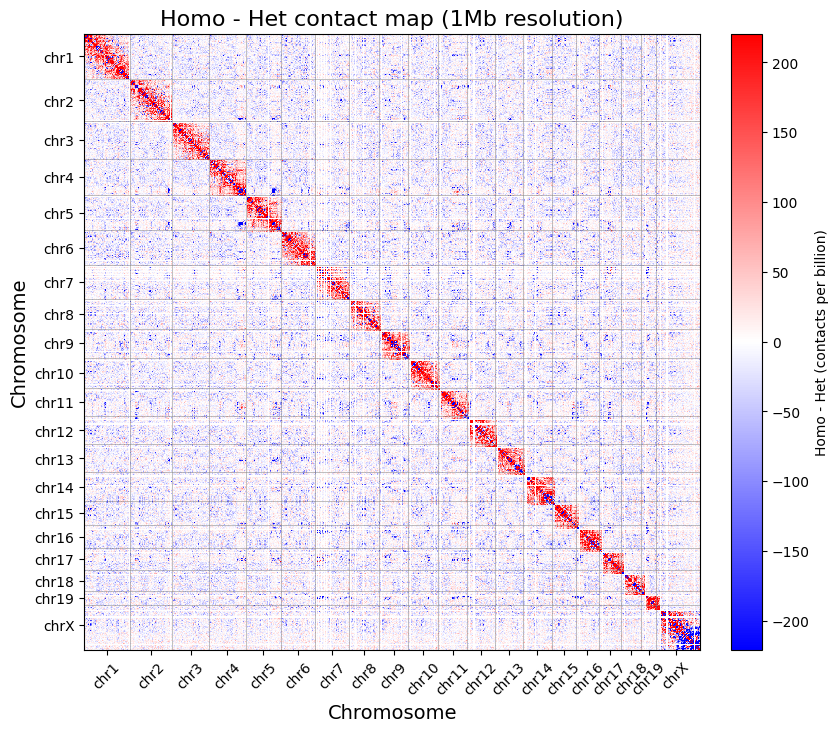


差值矩阵统计:
最大值: 260909.15
最小值: -100620.73
均值: 0.42
标准差: 325.25
99%分位点: 220.54


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import cooler
from collections import OrderedDict

# 设置参数
resolution = 1000000  # 1Mb
chromosomes_to_plot = [f'chr{i}' for i in range(1, 20)] + ['chrX']

# 指定样本名
sample_homo = 'Homo'
sample_het = 'Het'
data_dir = '/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output'

# 函数：加载contact frequency并裁剪到指定染色体
def load_contact_freq_subset(sample):
    clr = cooler.Cooler(f'{data_dir}/{sample}/{sample}.valid_pairs.5000.zoomify.mcool::resolutions/{resolution}')
    bins = clr.bins()[:]
    pixels = clr.pixels()[:]
    weights = bins["weight"].values
    bin1_weights = weights[pixels["bin1_id"].values]
    bin2_weights = weights[pixels["bin2_id"].values]
    balanced_counts = pixels["count"].values * bin1_weights * bin2_weights
    valid_mask = ~(np.isnan(bin1_weights) | np.isnan(bin2_weights))
    valid_pixels = pixels[valid_mask]
    valid_counts = balanced_counts[valid_mask]
    
    n_bins = len(bins)
    mat = coo_matrix((valid_counts, (valid_pixels["bin1_id"], valid_pixels["bin2_id"])), shape=(n_bins, n_bins)).todense()
    mat = np.array(mat)
    mat = mat + mat.T
    np.fill_diagonal(mat, np.diag(mat) / 2)
    mat /= mat.sum()
    mat *= 1e9  # normalized to per billion contacts
    mat = np.nan_to_num(mat)
    
    # 筛选出chr1-19 + X 的bin索引
    chroms = bins["chrom"].values
    mask = np.isin(chroms, chromosomes_to_plot)
    mat = mat[mask][:, mask]
    
    # 返回 contact map 和 clr 以获取 chromsizes
    return mat, clr, mask

# 加载两个样本
cf_homo, clr_homo, mask_homo = load_contact_freq_subset(sample_homo)
cf_het, clr_het, mask_het = load_contact_freq_subset(sample_het)

# 确保大小一致
assert cf_homo.shape == cf_het.shape

# 差值矩阵
diff_matrix = cf_homo - cf_het

# 从 chromsizes 中筛选只保留 chr1–chr19 和 chrX 的项
chromsizes_filtered = {chrom: size for chrom, size in clr_homo.chromsizes.items() if chrom in chromosomes_to_plot}

# 计算染色体起始位置和中心位置
chromstarts_new = []
chrom_centers = []
current_start = 0

for chrom in chromosomes_to_plot:
    bins_in_chrom = chromsizes_filtered[chrom] // resolution
    chromstarts_new.append(current_start)
    
    # 计算染色体中心位置
    chrom_center = current_start + bins_in_chrom // 2
    chrom_centers.append(chrom_center)
    
    current_start += bins_in_chrom

print(f"染色体起始位置: {chromstarts_new}")
print(f"染色体中心位置: {chrom_centers}")

# 绘图
plt.figure(figsize=(10, 8))
vmax = np.nanpercentile(np.abs(diff_matrix), 99)  # 控制颜色范围
im = plt.imshow(diff_matrix, cmap='bwr', vmin=-vmax, vmax=vmax, interpolation='none')
plt.colorbar(im, fraction=0.046, pad=0.04, label='Homo - Het (contacts per billion)')

# 使用染色体中心位置设置刻度
plt.xticks(chrom_centers, chromosomes_to_plot, rotation=45)
plt.yticks(chrom_centers, chromosomes_to_plot)

# 添加染色体边界线（使用起始位置）
for pos in chromstarts_new[1:]:  # 跳过第一个起始位置(0)
    plt.axvline(pos - 0.5, color='gray', lw=0.5, alpha=0.7)
    plt.axhline(pos - 0.5, color='gray', lw=0.5, alpha=0.7)

plt.title(f'Homo - Het contact map (1Mb resolution)', fontsize=16)
plt.xlabel('Chromosome', fontsize=14)
plt.ylabel('Chromosome', fontsize=14)

# 确保输出目录存在
os.makedirs('../plots', exist_ok=True)
plt.savefig(f'../plots_v1/{sample_homo}_minus_{sample_het}_contact_diffmap_1mb.pdf', dpi=300, bbox_inches='tight')
plt.show()

# 打印一些统计信息
print(f"\n差值矩阵统计:")
print(f"最大值: {np.nanmax(diff_matrix):.2f}")
print(f"最小值: {np.nanmin(diff_matrix):.2f}")
print(f"均值: {np.nanmean(diff_matrix):.2f}")
print(f"标准差: {np.nanstd(diff_matrix):.2f}")
print(f"99%分位点: {vmax:.2f}")